In [1]:
%reload_ext autoreload
%autoreload 2
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0" 
import tensorflow as tf
from tensorflow.keras import Sequential,Model,models
from tensorflow.keras.layers import Dense,Dropout,Flatten,BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print(f'Found {gpu} - allowing memory growth')
    tf.config.experimental.set_memory_growth(gpu, True)
cpus = tf.config.list_physical_devices('CPU')
for cpu in cpus:
    print(f'Found {cpu}')

Found PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') - allowing memory growth
Found PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
print(np.version.version)
from platform import python_version
print(python_version())
folder_path = "/content/drive/MyDrive/dataset/age_Images"
img_width=224
img_height=224
import scipy
import sklearn
print(scipy.__version__)
print(sklearn.__version__)

1.19.4
3.6.9
1.4.1
0.22.2.post1


In [ ]:
import os
images = []
target=[]
image_list = os.listdir(folder_path)

for i in range(len(image_list)):
    img = os.path.join(folder_path, image_list[i])
    img = image.load_img(img, target_size=(img_width,img_height))
    img = image.img_to_array(img)
    img = img/255.0
    images.append(img)
    target.append(image_list[i].split("_",1)[0])

images=np.array(images,dtype=np.float)
target=np.array(target,dtype=np.int)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(images,target, test_size=0.20, random_state=0)

In [ ]:
VGG16= tf.keras.applications.VGG16(
    input_shape=(img_width,img_height,3), include_top=False, weights='imagenet')

In [ ]:
for layer in VGG16.layers:
    layer.trainable = False

In [ ]:
x = VGG16.output
# let's add a fully-connected layer
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)

# this is the model we will train
model = Model(inputs=VGG16.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [109]:
# model.compile(
#   loss='mse',
#   optimizer='adam',
#   metrics=['mae', 'mape', 'mse' ]
# )

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [110]:
history=model.fit(X_train,y_train,batch_size=128,validation_data=(X_valid,y_valid),epochs=50)

Epoch 1/50
5/5 [==============================] - 4s 688ms/step - loss: 1.0337 - root_mean_squared_error: 0.9375 - val_loss: 113.1955 - val_root_mean_squared_error: 10.6393
Epoch 2/50
5/5 [==============================] - 3s 668ms/step - loss: 0.8341 - root_mean_squared_error: 0.8997 - val_loss: 102.8729 - val_root_mean_squared_error: 10.1426
Epoch 3/50
5/5 [==============================] - 3s 673ms/step - loss: 0.5187 - root_mean_squared_error: 0.7088 - val_loss: 109.8379 - val_root_mean_squared_error: 10.4804
Epoch 4/50
5/5 [==============================] - 3s 679ms/step - loss: 0.3801 - root_mean_squared_error: 0.6115 - val_loss: 104.5104 - val_root_mean_squared_error: 10.2230
Epoch 5/50
5/5 [==============================] - 3s 694ms/step - loss: 0.2092 - root_mean_squared_error: 0.4563 - val_loss: 106.8748 - val_root_mean_squared_error: 10.3380
Epoch 6/50
5/5 [==============================] - 3s 695ms/step - loss: 0.0978 - root_mean_squared_error: 0.3064 - val_loss: 106.2087 -

## Evaluation

In [113]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on validation data")
results = model.evaluate(X_valid, y_valid, batch_size=128)
print("test loss, test accuracy:", results)


Evaluate on validation data
2/2 [==============================] - 1s 128ms/step - loss: 105.9522 - root_mean_squared_error: 10.2933
test loss, test accuracy: [105.95222473144531, 10.293310165405273]


In [114]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions")
y_pred = model.predict(X_valid)
print("predictions shape:", y_pred.shape)

Generate predictions
predictions shape: (160, 1)


In [115]:
 from sklearn.metrics import explained_variance_score
 explained_variance_score(y_valid, y_pred, multioutput='raw_values')

array([0.3041266])

In [116]:
from sklearn.metrics import max_error
max_error(y_valid, y_pred)

27.855321884155273

In [117]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_valid, y_pred)

105.95225815770046

In [118]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(y_valid, y_pred)

0.13228484392232295

In [120]:
from sklearn.metrics import r2_score
r2_score(y_valid, y_pred)

0.2663467184307601

In [121]:
from math import sqrt
rmse = sqrt(mean_squared_error(y_valid, y_pred))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 10.293


In [125]:
model.save('/home/hemlata/AML_maskdetection/vgg16_agenet.h5')

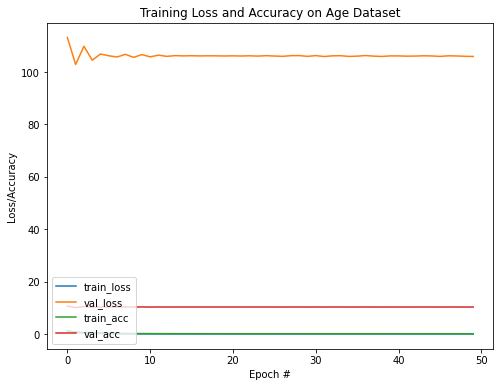

In [124]:
N = 50
#plt.style.use("ggplot")
plt.figure(figsize=(8,6))
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["root_mean_squared_error"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_root_mean_squared_error"], label="val_acc")
plt.title("Training Loss and Accuracy on Age Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()